<a href="https://colab.research.google.com/github/Mikepa22/Projects-IA/blob/main/Clasicaficacion_vinos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Miguel Angel Palomino Campo . CC:2235327**

# Librerias y carga dataset

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

**Acerca del dataset: winequality-white**

Link: http://archive.ics.uci.edu/dataset/186/wine+quality

Las entradas incluyen pruebas objetivas realizadas a muestras de vino blanco (por ejemplo, valores de PH, densidad, entre otras) y la salida se basa en datos sensoriales  (mediana de al menos 3 evaluaciones realizadas por expertos en vino). Cada experto calificó la calidad del vino  entre 0 (muy mala) y 10 (muy excelente).

Caracteristicas

   1 - `fixed acidity`

   2 - `volatile acidity`
   
   3 - `citric acid`

   4 - `residual sugar`

   5 - `chlorides`

   6 - `free sulfur dioxide`

   7 - `total sulfur dioxide`

   8 - `density`

   9 - `pH`

   10 - `sulphates`

   11 - `alcohol`

   Variable de salida (basada en datos sensoriales)
   
   
   12 - `quality` (calificacion entre 0 y 10)




In [ ]:
#cargar el dataset desde google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data = pd.read_csv('/content/drive/MyDrive/winequality-white.csv')
data.head()

Mounted at /content/drive


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Analisis exploratorio

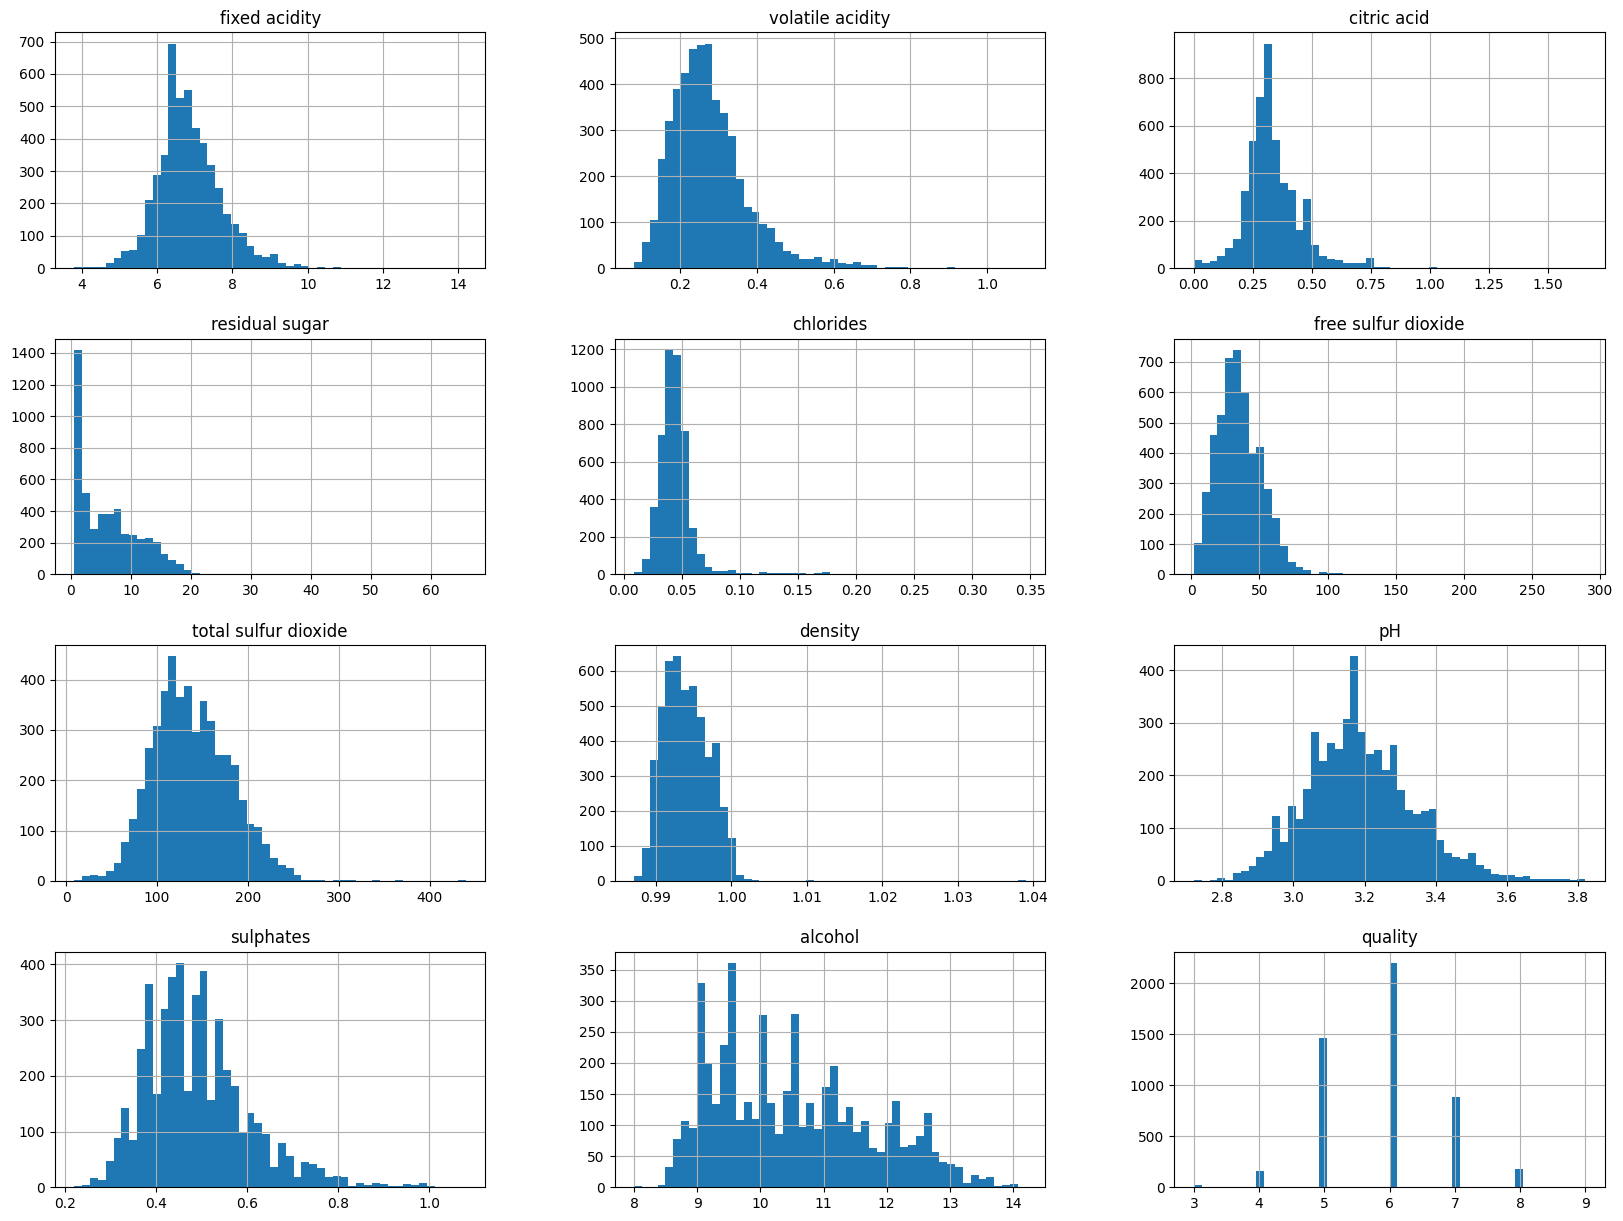

In [ ]:
#Histogramas para visualizar la distribucion de las variables
data.hist(bins=50,figsize=(20,15))
plt.show()

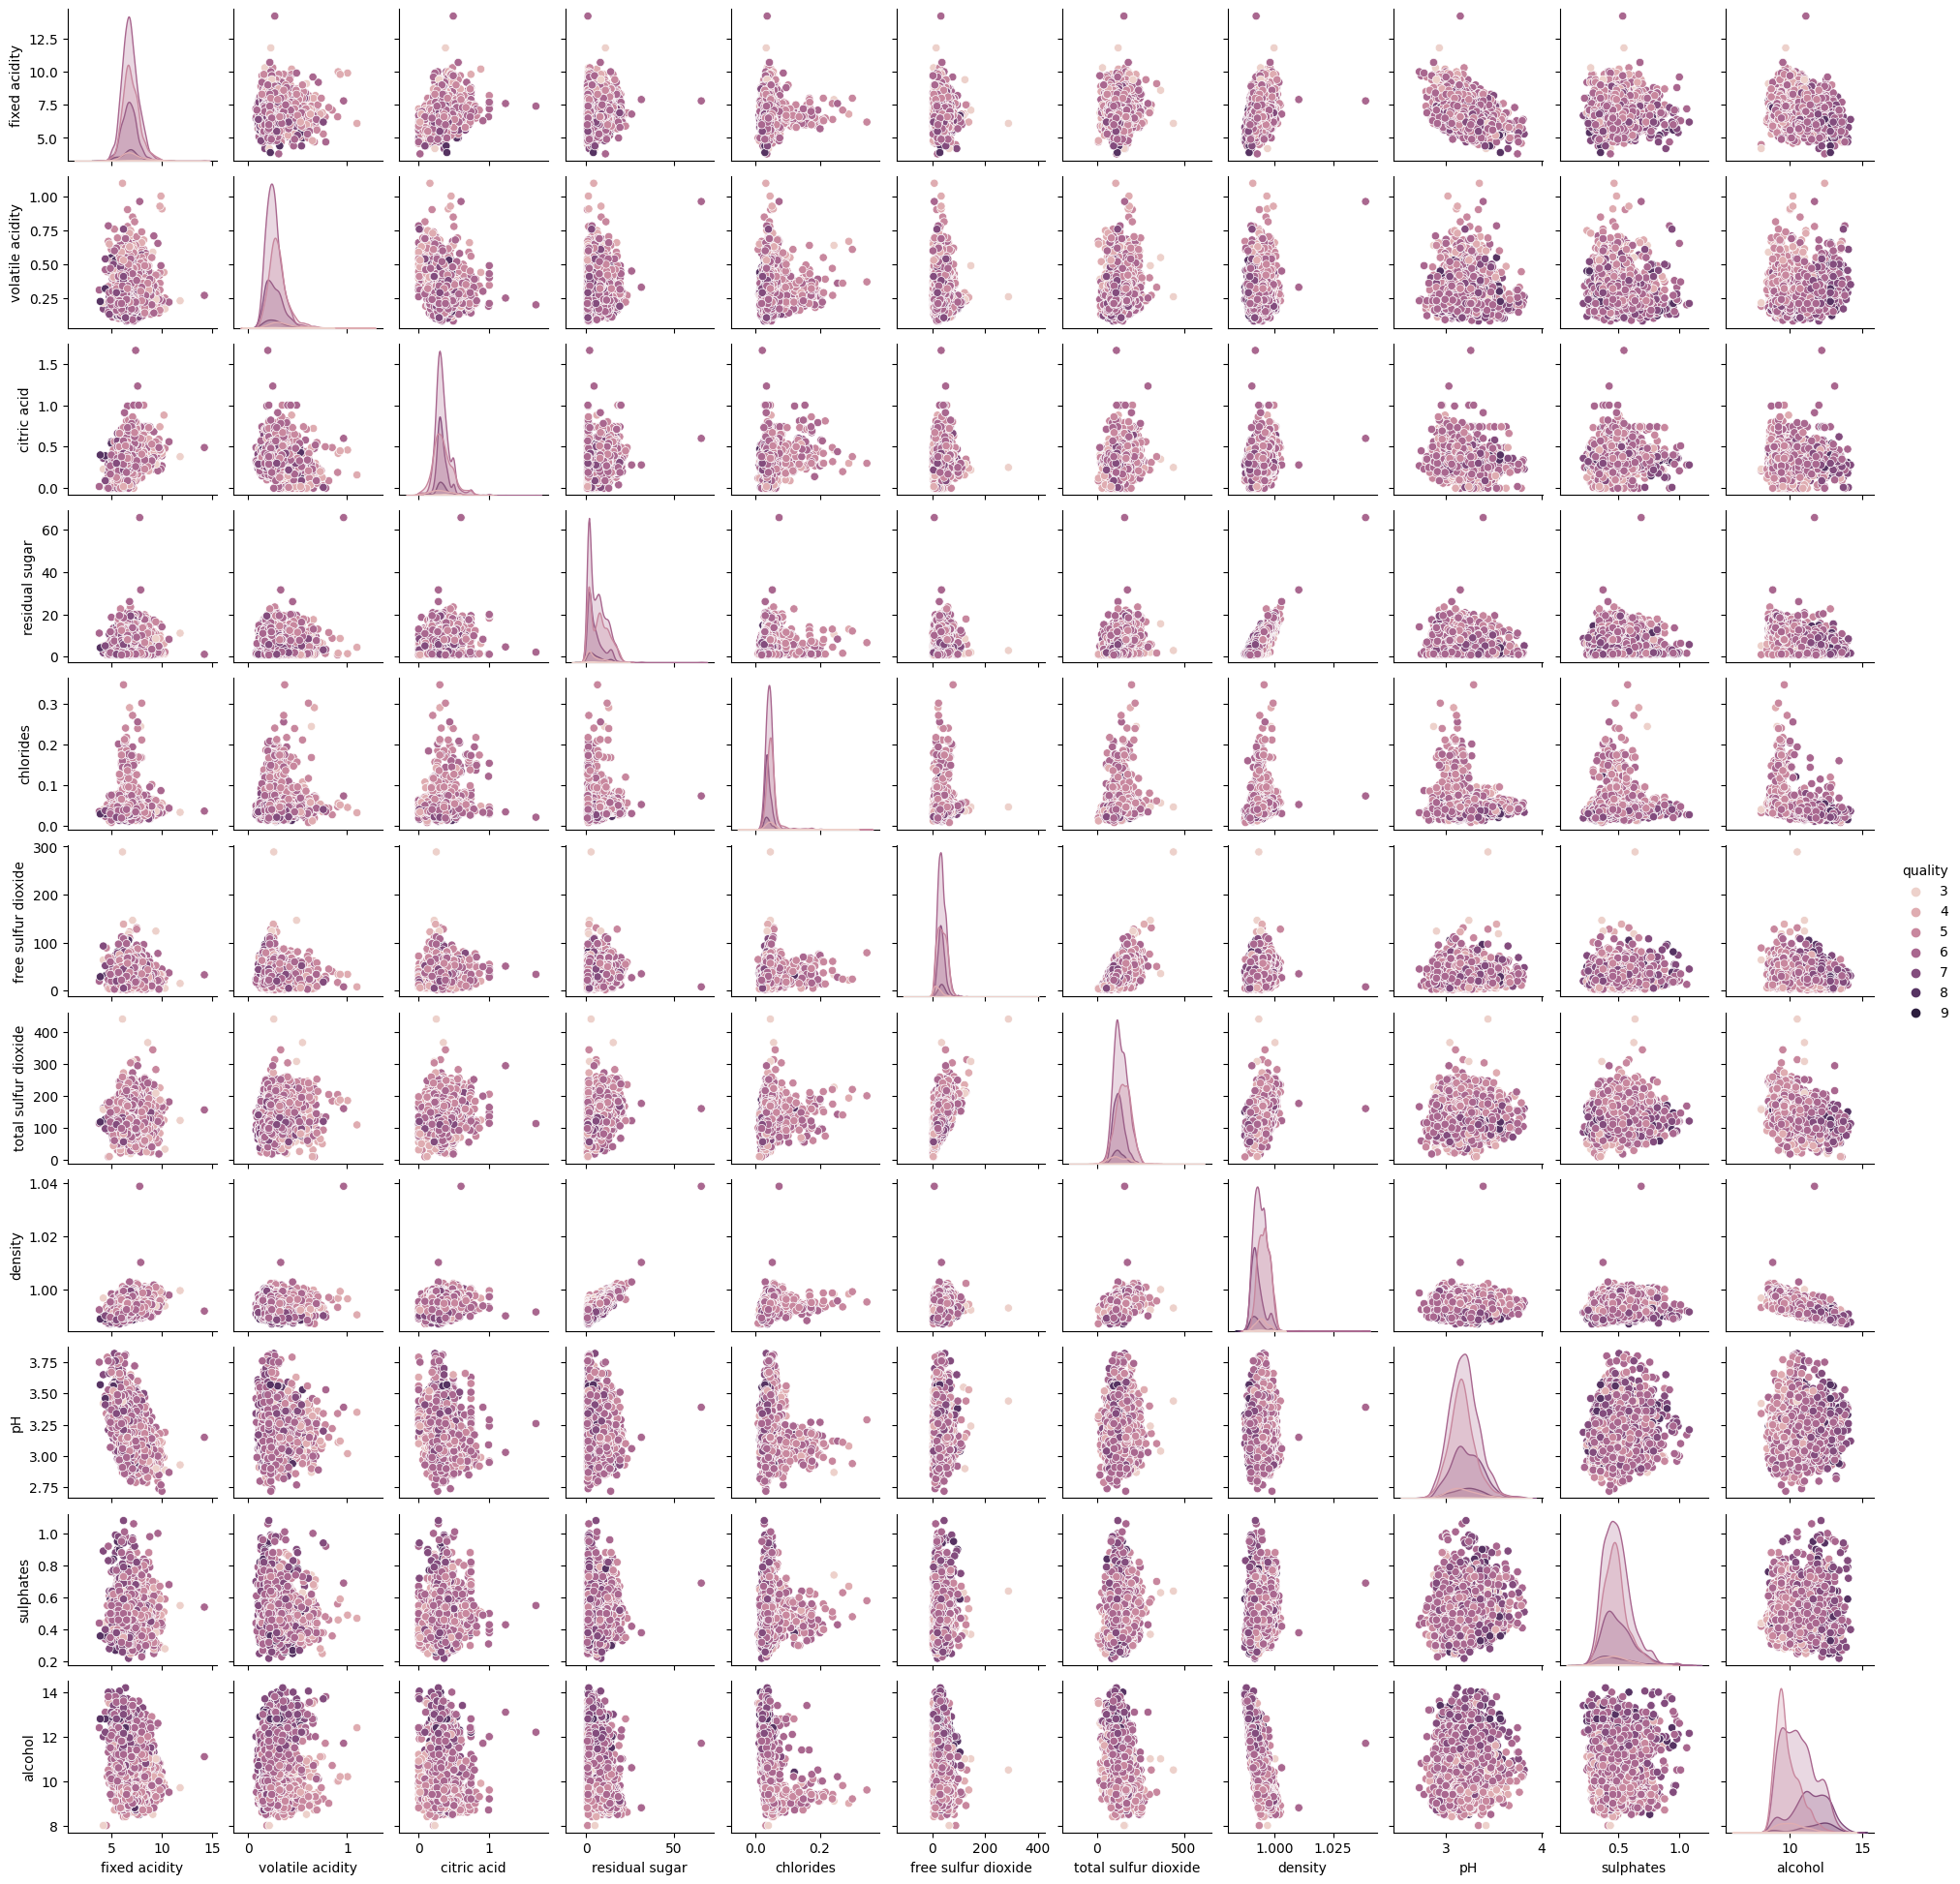

In [ ]:
# Visualizar como influye cada variable en la determinacion de la clase de salida
sns.pairplot(data,hue="quality",height=1.8)
plt.show()

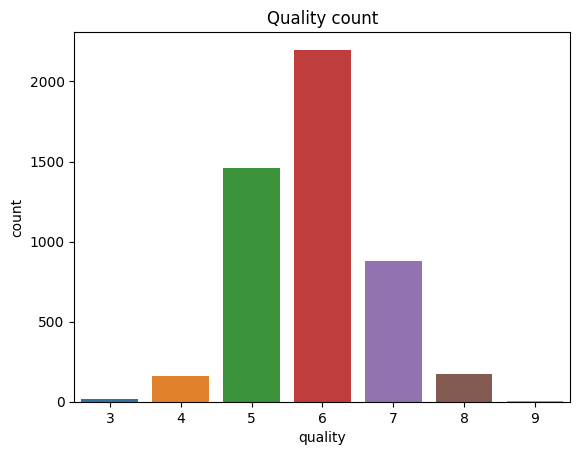

In [ ]:
#Conteo de la cantidad de registros existentes para cada valor de la salida
plt.title('Quality count')
sns.countplot(x = data['quality'])
plt.show()

Se observa un desbalance evidente en los datos, por lo que se procedera a utilizar una tecnica de balanceo en el preprocesamiento

# Preprocesamiento

## Balanceo

In [ ]:
#Separacion variables de entrada y variable de salida
X = data.drop(['quality'], axis=1)
Y = data['quality'].values
print(X.shape)
print(Y.shape)

(4898, 11)
(4898,)


**SMOTE**

Es una técnica de sobremuestreo en la que las muestras sintéticas se generan para la clase minoritaria. Este algoritmo ayuda a superar el problema de sobreajuste que plantea el random oversampling. Se centra en el espacio de características para generar nuevas instancias con la ayuda de la interpolación entre las instancias positivas que se encuentran juntas.

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE #Cargar SMOTE

# Iinializar smote con el valor de elementos requerido para cada clase
desired_ratios = {3: 2198, 4: 2198, 5: 2198, 7:2198 ,8: 2198, 9: 2198}
smote = SMOTE(sampling_strategy=desired_ratios, k_neighbors=4, random_state=42)

# Ajustar y aplicar SMOTE para balancear
X_resampled, y_resampled = smote.fit_resample(X, Y)

# Check the distribution of the classes after SMOTE
unique, cuenta = np.unique(y_resampled, return_counts=True)
numero_clases = dict(zip(unique, cuenta))
print("Distribucion de clases:", numero_clases)

Distribucion de clases: {3: 2198, 4: 2198, 5: 2198, 6: 2198, 7: 2198, 8: 2198, 9: 2198}


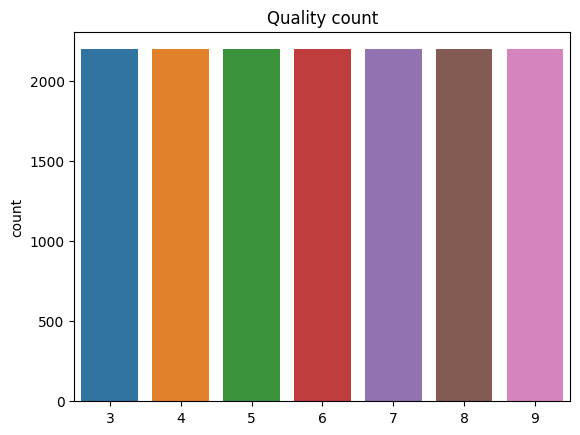

In [ ]:
plt.title('Quality count')
sns.countplot(x = y_resampled)
plt.show()

## Analisis variables estimadoras

In [ ]:
#Buscamos valores nulos
missing = (X_resampled.isnull().sum() / len(X_resampled)).sort_values(ascending = False)
missing = missing.index[missing > 0.5]
all_missing = list(set(missing))
print('Hay %d columnas con mas del 50%% de valores faltantes' % len(all_missing))

Hay 0 columnas con mas del 50% de valores faltantes


In [ ]:
# Comprobamos la varianza
v_thres = VarianceThreshold(threshold=0)
v_thres.fit(X_resampled)
Cols = X_resampled.columns[v_thres.get_support()]
X_resampled = v_thres.transform(X_resampled)
X_resampled = pd.DataFrame(X_resampled,columns=Cols)
X_resampled.shape

(15386, 11)

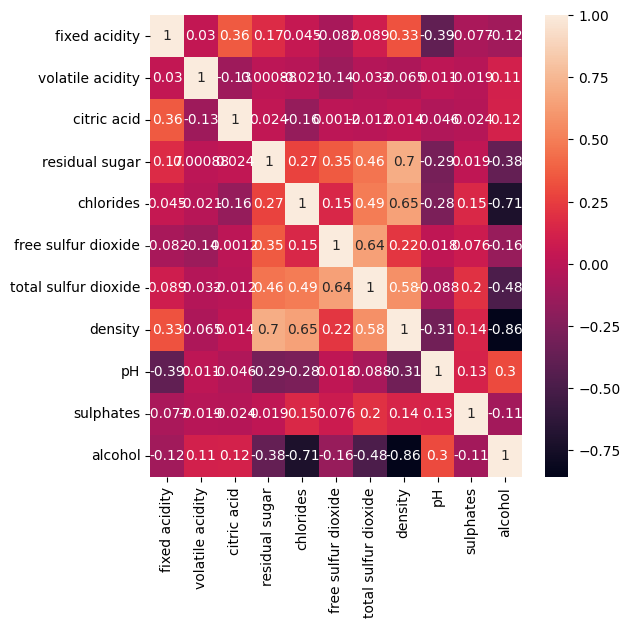

In [ ]:
#Creamos una matriz de correlacion para identicar que caracteristicas estan altamente correlacionadas
plt.figure(1, figsize = (6,6))
correlacion = X_resampled.corr(method = "spearman")
sns.heatmap(correlacion,annot=True)
plt.show()

In [ ]:
#Buscamos y eliminamos las variables que presenten un indice de colinealidad mayor a 0.8
threshold = 0.8 # Alta correlacion
corr_matrix = X_resampled.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))
print(to_drop)
X_resampled = X_resampled.drop(to_drop, axis=1)
print(X_resampled.shape)

There are 1 columns to remove.
['alcohol']
(15386, 10)


# Scaler y split

In [ ]:
#Uso de MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1.fit(X_resampled)
X_n=scaler1.transform(X_resampled)
X_n = np.array(X_n)

In [ ]:
# 80 % entrenamiento, 20 % validacion
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=12)
print("Training Data:", X_train.shape,y_train.shape)
print("Testing Data:", X_test.shape,y_test.shape)

Training Data: (12308, 10) (12308,)
Testing Data: (3078, 10) (3078,)


# Metrica nueva: AUC-ROC

**Área bajo la curva ROC (Receiver Operating Characteristic)**  

AUC - ROC es una medida de rendimiento para los problemas de clasificación en varios ajustes de umbral. ROC es una curva de probabilidad y AUC representa el grado o medida de separabilidad. Indica hasta qué punto el modelo es capaz de distinguir entre clases. Cuanto mayor es el area bajo la curva, mejor es el modelo a la hora de predecir 0 como 0 y 1 como 1



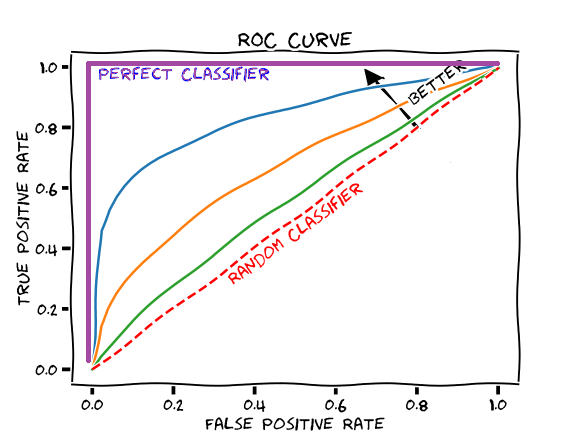

**Método para calcular la puntuación AUC de un problema de clasificación multiclase**

**Uno contra todos:** consiste en dividir el conjunto de datos multiclase en varios problemas de clasificación binaria. A continuación, se entrena un clasificador binario en cada problema de clasificación binaria y las predicciones se realizan utilizando el modelo más fiable.

In [ ]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

    # crear un conjunto de todas las clases únicas utilizando la lista de clases real

    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:

        # crear una lista de todas las clases excepto la clase actual
        other_class = [x for x in unique_class if x != per_class]

        # marcando la clase actual como 1 y todas las demás clases como 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # utilizando el método de métricas sklearn para calcular la puntuación roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

# Modelo regresion logistica

In [ ]:
from sklearn import linear_model
LogReg = linear_model.LogisticRegression(C=1,
                                         max_iter=400,
                                         solver='newton-cg',
                                         multi_class='ovr')

In [ ]:
LogReg.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=400, multi_class='ovr', solver='newton-cg')

In [ ]:
print("Coeficientes:", LogReg.coef_)
print("\nInterceptos: ", LogReg.intercept_)

Coeficientes: [[ 7.36252460e-01  6.77162625e-01 -1.40650363e+00  1.05242698e-03
   8.03384163e+00  6.08323405e-03  8.37647285e-03 -3.77054805e+00
   3.47047680e-01 -3.70712200e+00]
 [ 1.48528446e-02  4.86967364e+00 -2.19415374e+00 -9.62007618e-02
   1.92736004e+00 -6.21644045e-02  9.59762458e-03  1.85983252e+00
  -1.33534886e+00  5.43463916e-02]
 [-4.57485812e-01 -5.75369555e-01  5.16778622e-01  3.96293358e-02
   1.96888686e+00 -1.29283932e-02  9.66077284e-03  3.86076012e+00
  -2.04073557e+00 -7.36276029e-01]
 [-4.14694739e-01 -5.00789858e+00  4.18340655e-01  3.77210319e-02
   7.70888803e-01 -3.99020407e-03  1.12903160e-03  2.72090696e+00
  -1.18278837e+00  1.14151269e+00]
 [-4.22367664e-01 -4.90320589e+00 -1.33484173e+00 -3.91598048e-03
  -4.20341183e+00  4.22060213e-03 -6.71730105e-03  2.54613161e+00
  -9.83508909e-01  2.34930763e+00]
 [-5.87413292e-01 -1.13920714e+00  2.35646265e-01  4.07628628e-02
  -2.96022808e+00  1.59060039e-02 -1.08894978e-02  2.00307735e+00
  -6.44009939e-01  

## Metricas

### Datos entrenamiento

In [ ]:
#Prueba con datos de entrenamiento
y_pred_LogReg = LogReg.predict(X_train)
print(classification_report(y_train, y_pred_LogReg,zero_division=True))

              precision    recall  f1-score   support

           3       0.40      0.35      0.37      1768
           4       0.47      0.63      0.54      1742
           5       0.38      0.32      0.35      1765
           6       0.24      0.12      0.16      1775
           7       0.33      0.33      0.33      1751
           8       0.31      0.21      0.25      1731
           9       0.56      1.00      0.72      1776

    accuracy                           0.42     12308
   macro avg       0.39      0.42      0.39     12308
weighted avg       0.39      0.42      0.39     12308



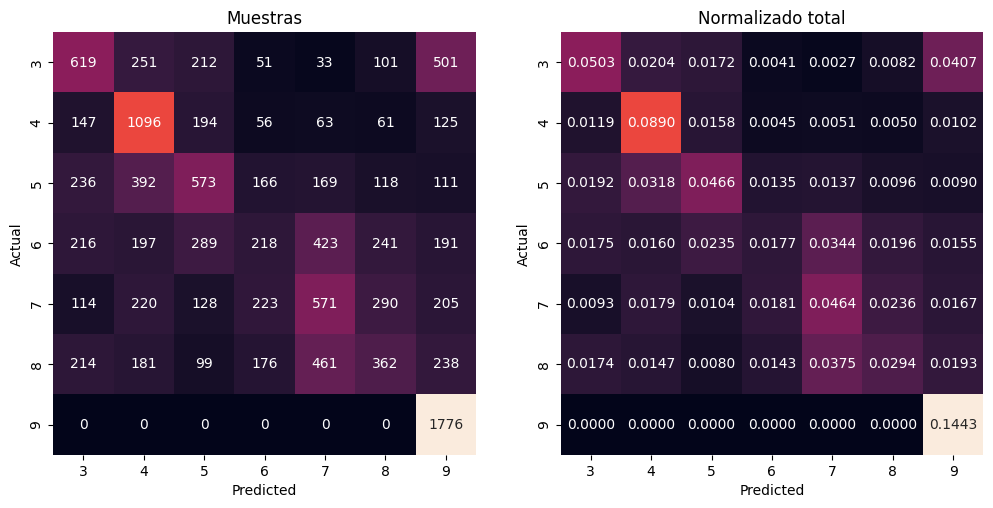

In [ ]:
#Matriz de confusion datos entrenamiento
fig,ax = plt.subplots(figsize=(12,6),ncols=2,nrows=1)
custom_labels = [ "3", "4", "5", "6", "7", "8", "9"]

sns.heatmap(confusion_matrix(y_train, y_pred_LogReg),
            annot=True,ax=ax[0],square=True, cbar=False,xticklabels=custom_labels, yticklabels=custom_labels, fmt='d')
sns.heatmap(confusion_matrix(y_train, y_pred_LogReg,normalize='all'),
            annot=True,ax=ax[1],fmt=".4f",square=True, cbar=False,xticklabels=custom_labels, yticklabels=custom_labels)

ax[0].set(xlabel="Predicted",ylabel="Actual", title="Muestras")
ax[1].set(xlabel="Predicted",ylabel="Actual", title="Normalizado total")
plt.show()

### Datos validacion

In [ ]:
#prueba con datos de validacion
y_pred_LogReg_T = LogReg.predict(X_test)
print(classification_report(y_test, y_pred_LogReg_T,zero_division=True))

              precision    recall  f1-score   support

           3       0.40      0.36      0.38       430
           4       0.48      0.59      0.53       456
           5       0.41      0.32      0.36       433
           6       0.27      0.15      0.19       423
           7       0.32      0.31      0.32       447
           8       0.31      0.21      0.25       467
           9       0.52      1.00      0.68       422

    accuracy                           0.42      3078
   macro avg       0.39      0.42      0.39      3078
weighted avg       0.39      0.42      0.39      3078



In [ ]:
#Metrica ROC-AUC
roc_auc_dict = roc_auc_score_multiclass(y_test, y_pred_LogReg_T)
roc_auc_dict

{3: 0.6342891519707722,
 4: 0.7408943554538521,
 5: 0.6225118638592141,
 6: 0.5412709860960853,
 7: 0.6003688596726179,
 8: 0.5621079324255722,
 9: 0.9265813253012049}

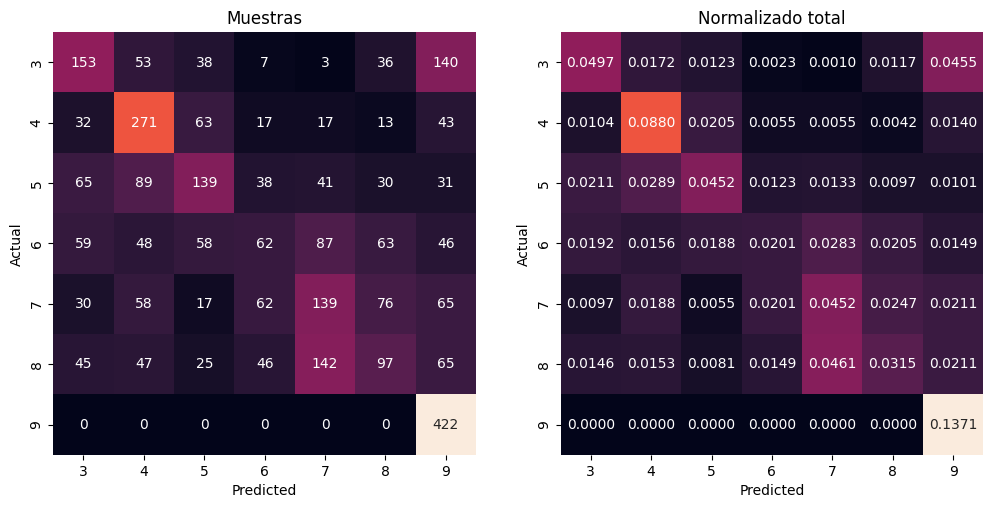

In [ ]:
#Matriz de confusion datos de validacion, usando seaborn
fig,ax = plt.subplots(figsize=(12,6),ncols=2,nrows=1)
custom_labels = [ "3", "4", "5", "6", "7", "8", "9"]

sns.heatmap(confusion_matrix(y_test, y_pred_LogReg_T),
            annot=True,ax=ax[0],square=True, cbar=False,xticklabels=custom_labels, yticklabels=custom_labels, fmt='d')
sns.heatmap(confusion_matrix(y_test, y_pred_LogReg_T,normalize='all'),
            annot=True,ax=ax[1],fmt=".4f",square=True, cbar=False,xticklabels=custom_labels, yticklabels=custom_labels)

ax[0].set(xlabel="Predicted",ylabel="Actual", title="Muestras")
ax[1].set(xlabel="Predicted",ylabel="Actual", title="Normalizado total")
plt.show()

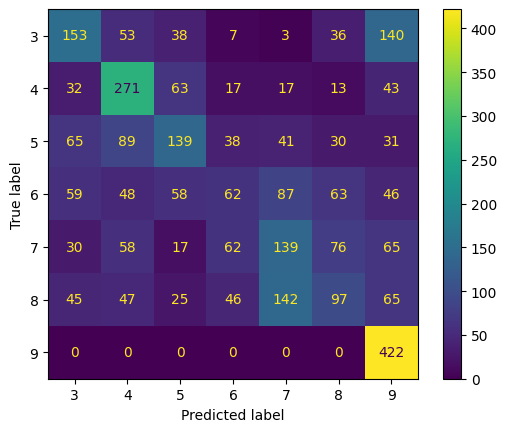

In [ ]:
#Matriz de confusion validacion, usando libreria sklearn
from sklearn import metrics
metrics.ConfusionMatrixDisplay.from_estimator(LogReg, X_test, y_test)

# Regresion Logistica sin balanceo

Una prueba para verificar el efecto del uso de balanceo en las metricas del modelo de regresion logistica

In [ ]:
X2=X.drop(['density'],axis=1) #Variable que presenta colinealidad mayor a 0.8

In [ ]:
#  Nuevo split usando los datos sin balancear. 80 % entrenamiento, 20 % validacion
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=0.2, random_state=27)
print("Training Data:", X_train2.shape,y_train2.shape)
print("Testing Data:", X_test2.shape,y_test2.shape)

Training Data: (3918, 10) (3918,)
Testing Data: (980, 10) (980,)


In [ ]:
LogReg.fit(X_train2, y_train2) #Ajuste con los mismos hiperparametros

LogisticRegression(C=1, max_iter=400, multi_class='ovr', solver='newton-cg')

In [ ]:
#prueba con datos de validacion
y_pred_LogReg_T2 = LogReg.predict(X_test2)
print(classification_report(y_test2, y_pred_LogReg_T2,zero_division=True))

              precision    recall  f1-score   support

           3       1.00      0.00      0.00         4
           4       1.00      0.00      0.00        27
           5       0.54      0.55      0.54       264
           6       0.55      0.77      0.64       471
           7       0.53      0.15      0.23       175
           8       1.00      0.00      0.00        38
           9       1.00      0.00      0.00         1

    accuracy                           0.55       980
   macro avg       0.80      0.21      0.20       980
weighted avg       0.58      0.55      0.50       980



In [ ]:
#ROC- AUC
roc_auc_dict = roc_auc_score_multiclass(y_test2, y_pred_LogReg_T2)
roc_auc_dict

{3: 0.5,
 4: 0.5,
 5: 0.6873307093279161,
 6: 0.5967072524703949,
 7: 0.5599999999999999,
 8: 0.5,
 9: 0.5}

Este analisis nos permite concluir que, aunque el modelo tiene una precision un 12 % mayor que cuando se entrena con los datos balanceados, la metrica AUC-ROC nos permite determinar que el modelo es de hecho, peor. Esto se debe a que, para cada clase, los valores estan mas cerca de aquellos que caracterizan a un clasificador aleatorio.

# Random forest classifier

**UNIDAD FUNDAMENTAL: ARBOLES DE DECISION**

Un árbol de decisión es un algoritmo de aprendizaje supervisado no paramétrico. Tiene una estructura jerárquica de árbol, que consta de un nodo raíz, ramas, nodos internos y nodos hoja. Un árbol de decisión comienza con un nodo raíz, que no tiene ramas entrantes. Las ramas salientes del nodo raíz alimentan los nodos internos, también conocidos como nodos de decisión. Basándose en las características disponibles, ambos tipos de nodos realizan evaluaciones para formar subconjuntos homogéneos, que se denominan nodos hoja o nodos terminales. Los nodos hoja representan todos los resultados posibles dentro del conjunto de datos



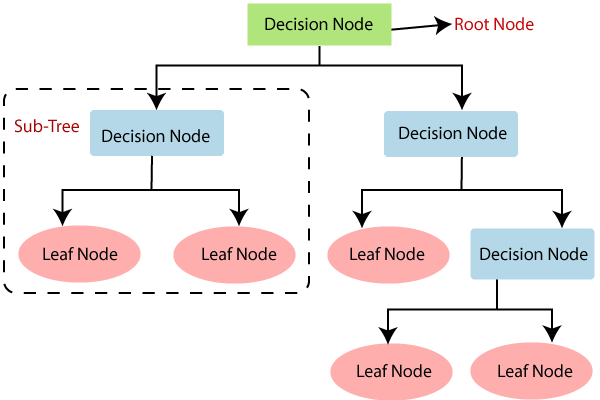



**Pasos del algoritmo Random Forest**

***Paso 1:*** En el modelo Random Forest, se selecciona un subconjunto de salidas y un subconjunto de características para construir cada árbol de decisión. En pocas palabras, se toman n registros aleatorios y m características del conjunto de datos que tiene k registros.

***Paso 2:*** Se construyen árboles de decisión individuales para cada muestra.

***Paso 3: *** Cada árbol de decisión genera un resultado.

***Paso 4:*** El resultado final se considera basado en la Votación por Mayoría o el Promedio para la Clasificación y la Regresión, respectivamente.

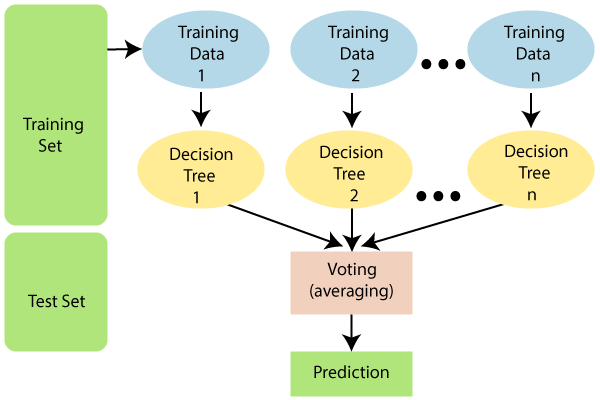

In [ ]:
# Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(criterion='gini', # como dividir el nodo en cada arbol?
                                       max_depth=90,
                                       max_features=1 , #Número máximo de características que el bosque aleatorio considera para dividir un nodo
                                       min_samples_leaf=1 , #Determina el número mínimo de hojas necesarias para dividir un nodo interno
                                       min_samples_split=2,
                                       n_estimators=200, random_state=29)
# ajuste
rf_classifier.fit(X_train, y_train)
# prediccion
y_pred1 = rf_classifier.predict(X_test)


## Metricas

### Datos de entrenamiento





In [ ]:
#Prueba con datos de entrenamiento
y_pred2= rf_classifier.predict(X_train)
print(classification_report(y_train, y_pred2,zero_division=True))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00      1768
           4       1.00      1.00      1.00      1742
           5       1.00      1.00      1.00      1765
           6       1.00      1.00      1.00      1775
           7       1.00      1.00      1.00      1751
           8       1.00      1.00      1.00      1731
           9       1.00      1.00      1.00      1776

    accuracy                           1.00     12308
   macro avg       1.00      1.00      1.00     12308
weighted avg       1.00      1.00      1.00     12308



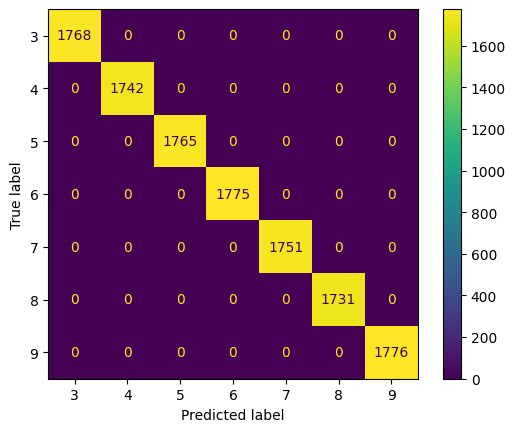

In [ ]:
#Matriz de confusion datos entrenamiento
from sklearn import metrics
metrics.ConfusionMatrixDisplay.from_predictions(y_train,y_pred2)

### Datos de validacion

In [ ]:
#prueba con datos de validacion
print(classification_report(y_test, y_pred1,zero_division=True))

              precision    recall  f1-score   support

           3       0.99      1.00      1.00       430
           4       0.91      0.97      0.94       456
           5       0.80      0.77      0.79       433
           6       0.70      0.64      0.67       423
           7       0.82      0.86      0.84       447
           8       0.95      0.95      0.95       467
           9       1.00      1.00      1.00       422

    accuracy                           0.89      3078
   macro avg       0.88      0.88      0.88      3078
weighted avg       0.88      0.89      0.88      3078



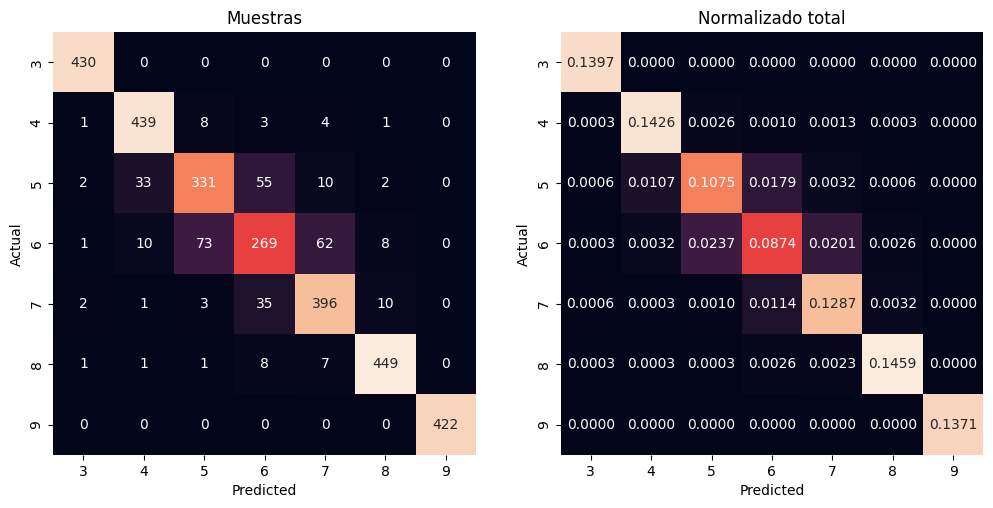

In [ ]:
#Matriz de confusion validacion, usando seaborn
fig,ax = plt.subplots(figsize=(12,6),ncols=2,nrows=1)
custom_labels = [ "3", "4", "5", "6", "7", "8", "9"]

sns.heatmap(confusion_matrix(y_test, y_pred1),
            annot=True,ax=ax[0],square=True, cbar=False,xticklabels=custom_labels, yticklabels=custom_labels, fmt='d')
sns.heatmap(confusion_matrix(y_test, y_pred1,normalize='all'),
            annot=True,ax=ax[1],fmt=".4f",square=True, cbar=False,xticklabels=custom_labels, yticklabels=custom_labels)

ax[0].set(xlabel="Predicted",ylabel="Actual", title="Muestras")
ax[1].set(xlabel="Predicted",ylabel="Actual", title="Normalizado total")
plt.show()

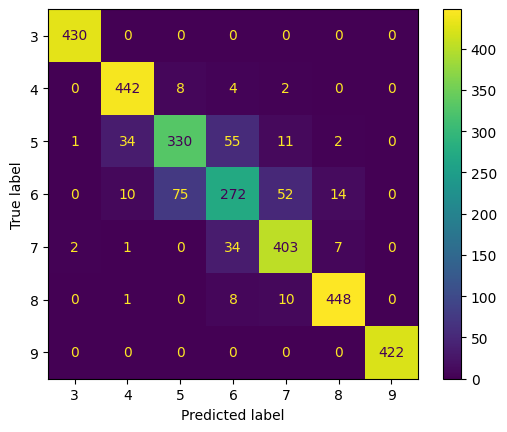

In [ ]:
#Matriz de confusion validacion, usando libreria sklearn
from sklearn import metrics
metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred1)

In [ ]:
#Metrica AUC-ROC datos validacion
roc_auc_dict = roc_auc_score_multiclass(y_test, y_pred1)
roc_auc_dict

{3: 0.9994335347432024,
 4: 0.9758771929824561,
 5: 0.8653723745617904,
 6: 0.8024922867331811,
 7: 0.9365298620730118,
 8: 0.9752529448380556,
 9: 1.0}